# Coursework Template

**Dependencies and imports**

This can take a minute...

In [13]:
# !pip install swig
# !pip install --upgrade rldurham

In [14]:
import torch
import rldurham as rld

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque

**Reinforcement learning agent**

Replace this with your own agent, I recommend starting with TD3 (lecture 8).

In [15]:
class RunningMeanStd:
    def __init__(self, shape=()):
        self.mean = np.zeros(shape, dtype=np.float32)
        self.var = np.ones(shape, dtype=np.float32)
        self.count = 1e-4
        
    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        
        delta = batch_mean - self.mean
        self.mean = self.mean + delta * batch_count / (self.count + batch_count)
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        self.var = M2 / (self.count + batch_count)
        self.count = self.count + batch_count

In [16]:
class Agent(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Agent, self).__init__()
        
        # State normalization
        self.state_rms = RunningMeanStd(shape=state_dim)
        
        # Policy network with separate mean and log_std outputs
        self.policy_base = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        self.action_mean = nn.Linear(hidden_dim, action_dim)
        self.action_log_std = nn.Parameter(torch.zeros(1, action_dim))
        
        # Value network
        self.value = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        # Initialize weights
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.orthogonal_(layer.weight, np.sqrt(2))
                layer.bias.data.zero_()
        
        # Memory and parameters
        self.trajectory = []
        self.gamma = 0.99
        self.learning_rate = 3e-4
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        self.running_rewards = deque(maxlen=100)
        self.clip_actions = True

    
    def normalize_state(self, state):
        """Normalize state using running mean and std"""
        if isinstance(state, np.ndarray):
            # Ensure state is 2D for batch processing
            if state.ndim == 1:
                state = state.reshape(1, -1)
            self.state_rms.update(state)
            state = (state - self.state_rms.mean) / np.sqrt(self.state_rms.var + 1e-8)
        return state
    
    def get_action_distribution(self, state):
        """Get the action distribution parameters for a given state"""
        features = self.policy_base(state)
        mean = self.action_mean(features)
        # Expand log_std to match the batch dimension of mean
        log_std = self.action_log_std.expand(*mean.shape)
        return mean, log_std
    
    def sample_action(self, state):
        """Sample action using the current policy"""
        # Normalize and convert state to tensor
        state = self.normalize_state(state)
        state = torch.FloatTensor(state)
        
        with torch.no_grad():
            # Get action distribution parameters
            mean, log_std = self.get_action_distribution(state)
            std = torch.exp(log_std)
            
            # Sample action using reparameterization trick
            normal = torch.randn_like(mean)
            action = mean + normal * std
            
            # Clip actions if needed
            if self.clip_actions:
                action = torch.clamp(action, -1.0, 1.0)
        
        # Return the first (and only) action if input was a single state
        return action.squeeze(0).numpy()
        return action.numpy()
    
    def put_data(self, state, action, reward, next_state, done):
        """Store transition in memory"""
        self.trajectory.append((state, action, reward, next_state, done))
    
    def train(self):
        """Update policy and value networks"""
        if len(self.trajectory) < 1:
            return
        
        # Unpack and normalize states
        states, actions, rewards, next_states, dones = zip(*self.trajectory)
        states = np.array(states)
        next_states = np.array(next_states)
        
        # Normalize states
        states = self.normalize_state(states)
        next_states = self.normalize_state(next_states)
        
        # Convert to tensors
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        # Compute returns and advantages
        with torch.no_grad():
            values = self.value(states).squeeze()
            next_values = self.value(next_states).squeeze()
            
            # Compute returns
            returns = []
            running_return = next_values[-1] * (1 - dones[-1])
            for r, d in zip(reversed(rewards), reversed(dones)):
                running_return = r + self.gamma * running_return * (1 - d)
                returns.insert(0, running_return)
            returns = torch.stack(returns)
            
            # Compute advantages
            advantages = returns - values
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Compute action distributions
        features = self.policy_base(states)
        mean = self.action_mean(features)
        log_std = self.action_log_std.expand_as(mean)
        std = torch.exp(log_std)
        
        # Compute log probabilities
        normal_dist = torch.distributions.Normal(mean, std)
        log_probs = normal_dist.log_prob(actions).sum(dim=1)
        
        # Policy loss using PPO-style objective
        policy_loss = -(log_probs * advantages).mean()
        
        # Value loss
        value_loss = F.mse_loss(self.value(states).squeeze(), returns)
        
        # Entropy bonus for exploration
        entropy = normal_dist.entropy().mean()
        
        # Total loss
        loss = policy_loss + 0.5 * value_loss - 0.01 * entropy
        
        # Update networks
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=0.5)
        self.optimizer.step()
        
        # Clear trajectory
        self.trajectory = []
        
        return loss.item()
    
    def update_stats(self, episode_reward):
        """Update running statistics"""
        self.running_rewards.append(episode_reward)
        
    def get_average_reward(self):
        """Get average reward over last 100 episodes"""
        return np.mean(self.running_rewards) if self.running_rewards else 0

**Prepare the environment and wrap it to capture statistics, logs, and videos**

The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


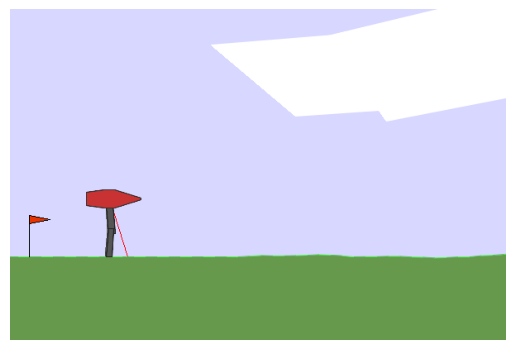

In [17]:
env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="xxxx00-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=42)
rld.render(env)

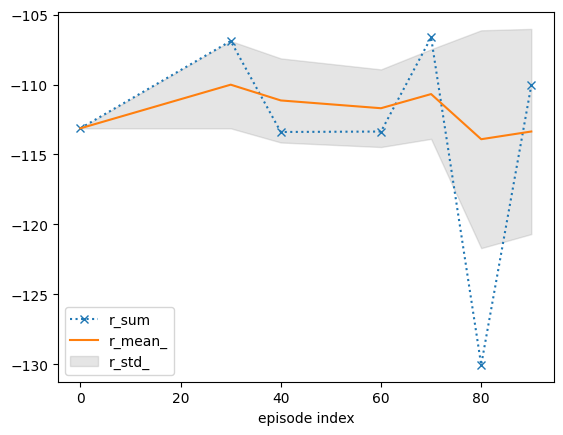

In [18]:
# in the submission please use seed_everything with seed 42 for verification
seed, observation, info = rld.seed_everything(42, env)

# initialise agent
agent = Agent(env.observation_space.shape[0], env.action_space.shape[0])
max_episodes = 100
max_timesteps = 2000

# track statistics for plotting
tracker = rld.InfoTracker()

# switch video recording off (only switch on every x episodes as this is slow)
env.video = False

# training procedure
for episode in range(max_episodes):
    
    # recording statistics and video can be switched on and off (video recording is slow!)
    env.info = episode % 10 == 0   # track every x episodes (usually tracking every episode is fine)
    env.video = episode % 10 == 0  # record videos every x episodes (set BEFORE calling reset!)

    # reset for new episode
    observation, info = env.reset()
    episode_reward = 0
    
    for t in range(max_timesteps):
    
        action = agent.sample_action(observation)
        next_observation, reward, terminated, truncated, info = env.step(action)
        
        episode_reward += reward
        done = terminated or truncated
            
        agent.put_data(observation, action, reward, next_observation, done)
        
        observation = next_observation
        
        if done:
            break
        
    loss = agent.train()
    agent.update_stats(episode_reward)

    # TRAIN THE AGENT HERE!
            
    # track and plot statistics
    tracker.track(info)
    if (episode + 1) % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

# don't forget to close environment (e.g. triggers last video save)
env.close()

# write log file (for coursework)
env.write_log(folder="logs", file="xxxx00-agent-log.txt")  # replace xxxx00 with your username

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...

In [19]:
from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

env = rld.make(
    "rldurham/Walker",
    # "BipedalWalker-v3",
    render_mode="human",
    # render_mode="rgb_array",
    hardcore=False,
    # hardcore=True,
)
_, obs, info = rld.seed_everything(42, env)

heuristics = BipedalWalkerHeuristics()

act = heuristics.step_heuristic(obs)
for _ in range(500):
    obs, rew, terminated, truncated, info = env.step(act)
    act = heuristics.step_heuristic(obs)
    if terminated or truncated:
        break
    if env.render_mode == "rgb_array":
        rld.render(env, clear=True)
env.close()

Seed set to 42
